In [17]:
import pandas as pd
import numpy as np

#Tensor flow
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers, Sequential, layers
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras
import matplotlib.pyplot  as plt

In [2]:
file_submission = 'data/sample_submission.csv'
file_train_data = 'data/train.csv'
file_test_data = 'data/test.csv'
df_sub = pd.read_csv(file_submission)
df_train = pd.read_csv(file_train_data)
df_test = pd.read_csv(file_test_data)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
# Cut percentage of train vs test
percentage_cut = 20
cut_test = len(df_train) * 20 // 100
cut_train = len(df_train) - cut_test

In [5]:
# Cut percentage of train vs test

X = df_train['text']
X_pred = df_test['text']
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X)

X_train_token = tokenizer.texts_to_sequences(X)
X_pred_token = tokenizer.texts_to_sequences(X_pred)

In [6]:
def percentage_loss(token_words, padding_max)->str:
    """
        Test the percentage loss after padding
        Example: percentage_loss(X_token, 25) => 'After padding loss: 1.22%'
    """
    
    get_over_lenght = len([tok for tok in token_words if len(tok) >= padding_max])
    percent = get_over_lenght * 100 / len(token_words)
    
    return f'After padding loss: {percent:.2f}%'

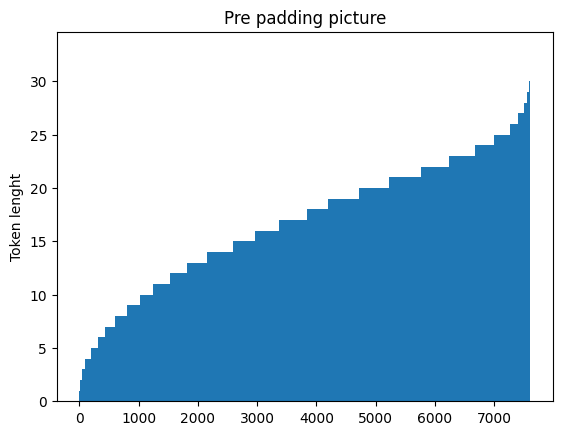

In [7]:
# Check the relevance of padding trading off performance

X_sort = sorted(X_train_token, key=lambda x: len(x))
plt.bar(x= np.arange(1, len(X_sort) + 1), height=[len(num) for num in X_sort], width=1)
plt.title('Pre padding picture')
plt.ylabel('Token lenght')
plt.show();

In [8]:
# Padding words
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='pre', maxlen=30)
X_pred_pad = pad_sequences(X_pred_token, dtype='float32', padding='pre')

X_train_pad = X_train_pad[:cut_train]
X_test_pad = X_train_pad[-cut_test:]

y_train = df_train['target'][:cut_train]
y_test = df_train['target'][-cut_test:]

In [25]:
# Initialize model and define vocabulary size
vocab_size = len(tokenizer.word_index)

def initialize_model():

    model = Sequential()
    
    model.add(layers.Embedding(
        input_dim= vocab_size + 1,
        input_length= 30, 
        output_dim = 1, 
        mask_zero = True
    ))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))

    
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [26]:
model = initialize_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 1)             22701     
                                                                 
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39662 (154.93 KB)
Trainable params: 39662 (154.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
es = EarlyStopping(patience=4, restore_best_weights=True)

history = model.fit(
    X_train_pad, 
    y_train, 
    batch_size=128, 
    epochs=20, 
    validation_data=(X_test_pad, y_test),
    callbacks = [es])

Epoch 1/20
48/48 [==============================] - 13s 220ms/step - loss: 0.6976 - accuracy: 0.5410 - val_loss: 0.6943 - val_accuracy: 0.5342
Epoch 2/20
48/48 [==============================] - 9s 187ms/step - loss: 0.6129 - accuracy: 0.6792 - val_loss: 0.7949 - val_accuracy: 0.5703
Epoch 3/20
48/48 [==============================] - 8s 168ms/step - loss: 0.2803 - accuracy: 0.9018 - val_loss: 1.5121 - val_accuracy: 0.5716
Epoch 4/20
48/48 [==============================] - 8s 171ms/step - loss: 0.1526 - accuracy: 0.9455 - val_loss: 1.9529 - val_accuracy: 0.5769
Epoch 5/20
48/48 [==============================] - 8s 166ms/step - loss: 0.0993 - accuracy: 0.9670 - val_loss: 2.0877 - val_accuracy: 0.5775


In [28]:
pred_res = model.predict(X_pred_pad)

102/102 [==============================] - 4s 30ms/step


<BarContainer object of 3263 artists>

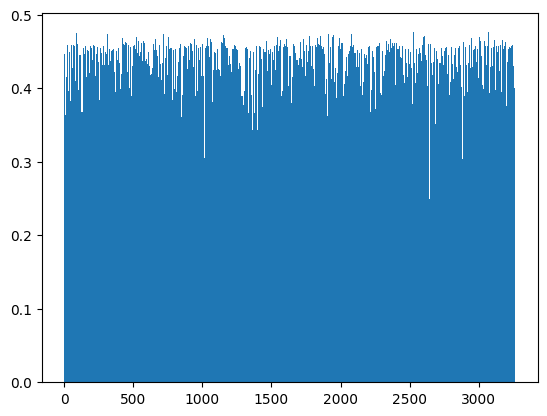

In [29]:
plt.bar(x= np.arange(1, len(pred_res) + 1), height= [float(res) for res in pred_res], width=1)

In [30]:
map_res = [1 if x > 0.5 else 0 for x in pred_res ]